In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

In [2]:
def load_images(image_folder, dpi = 100):
    image_files = os.listdir(image_folder)
    image_to_segmented = {}
    image_to_calib = {}
    for file in image_files:
        filename = file.split('.')[0].split('_')[0]
        if file.endswith('.png'):
            if filename not in image_to_segmented:
                image_to_segmented[filename] = []
            image_to_segmented[filename].append(file)
            if 'calib' in file:
                image_to_calib[filename] = file
    list_of_images = []
    for scrap_image, segmented_images in image_to_segmented.items():
        calib_image = Image.open(os.path.join(image_folder, image_to_calib[scrap_image]))
        calib_size = max(calib_image.size)
        for segmented_image in segmented_images:
            if segmented_image == image_to_calib[scrap_image]:
                continue
            segmented_img = Image.open(os.path.join(image_folder, segmented_image))
            new_size = int(segmented_img.size[0] / calib_size * dpi), int(segmented_img.size[1] / calib_size * dpi)
            resized_img = segmented_img.resize(new_size)
            list_of_images.append(resized_img)
    return list_of_images

def find_inner_bbox(image):
    w, h = image.size
    # print(w, h)
    image = np.array(image)
    # print(image.shape)
    init_ratio = 0.05
    inc_ratio = 0.01
    while inc_ratio <= 1 - init_ratio:
        xi = int(w * (1 - init_ratio - inc_ratio) / 2)
        xj = w - xi
        yi = int(h * (1 - init_ratio - inc_ratio) / 2)
        yj = h - yi
        curr_block = image[yi:yj, xi:xj, :]
        num_zeros = ((curr_block[:, :, 0] == 0) & (curr_block[:, :, 1] == 0) & (curr_block[:, :, 2] == 0) & (curr_block[:, :, 3] == 0)).sum()
        if num_zeros < 0.001 * w * h:
            # expand the bounding box
            inc_ratio += 0.005
        else:
            # shrink the bounding box
            # print(num_zeros, w * h)
            break
    xi = int(w * (1 - init_ratio - inc_ratio) / 2)
    xj = w - xi
    yi = int(h * (1 - init_ratio - inc_ratio) / 2)
    yj = h - yi
    return Image.fromarray(image[yi:yj, xi:xj]).convert('RGBA')

def align_image(image):
    """Find the minimum area rotated rectangle and align the image with axes."""
    # Convert PIL to cv2
    cv_image = np.array(image)
    
    # Create binary mask from alpha channel
    alpha_mask = cv_image[:, :, 3] > 0
    alpha_mask = alpha_mask.astype(np.uint8) * 255
    
    # Find contours
    contours, _ = cv2.findContours(alpha_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return image
    
    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get the minimum area rectangle
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = box.astype(np.int32)

    # Get the angle to rotate the image
    angle = rect[-1]
    if angle < -45:
        angle = 90 + angle
    
    # Calculate new dimensions to avoid cropping
    height, width = cv_image.shape[:2]
    center = (width // 2, height // 2)
    
    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Calculate new image dimensions
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))
    
    # Adjust the rotation matrix
    M[0, 2] += (new_width / 2) - center[0]
    M[1, 2] += (new_height / 2) - center[1]
    
    # Perform the rotation
    rotated = cv2.warpAffine(cv_image, M, (new_width, new_height),
                            flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT,
                            borderValue=(0, 0, 0, 0))
    
    # Convert back to PIL
    aligned_image = Image.fromarray(rotated)
    
    return aligned_image

def find_inner_bbox_aligned(image):
    """Find inner bounding box of an axis-aligned image."""
    # First align the image
    aligned = align_image(image)
    
    # Convert to numpy array
    image_array = np.array(aligned)
    
    # Find non-transparent pixels
    non_transparent = image_array[:, :, 3] > 0
    
    # Find the bounding box
    rows = np.any(non_transparent, axis=1)
    cols = np.any(non_transparent, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    
    # Add some padding (e.g., 5% of the dimension)
    h, w = ymax - ymin, xmax - xmin
    padding_y = int(h * 0.05)
    padding_x = int(w * 0.05)
    
    ymin = max(0, ymin - padding_y)
    ymax = min(image_array.shape[0], ymax + padding_y)
    xmin = max(0, xmin - padding_x)
    xmax = min(image_array.shape[1], xmax + padding_x)
    
    # Crop the image
    cropped = image_array[ymin:ymax, xmin:xmax]
    return Image.fromarray(cropped)

def plot_original_and_processed_images(list_of_images, processed_images):
    # Plot a grid of original vs processed images
    n_images = len(list_of_images)
    n_cols = 4  # 2 images (original + processed) per row
    n_rows = (n_images + 1) // 2  # Ceiling division to get number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i in range(n_images):
        # Original image
        axes[i*2].imshow(list_of_images[i])
        axes[i*2].set_title(f'Original {i+1}')
        axes[i*2].axis('off')
        
        # Aligned image
        axes[i*2 + 1].imshow(processed_images[i])
        axes[i*2 + 1].set_title(f'Processed {i+1}')
        axes[i*2 + 1].axis('off')

    # Hide any unused subplots
    for i in range(n_images * 2, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def save_images(image_folder, images):
    if not os.path.exists(f'{image_folder}_pp'):
        os.mkdir(f'{image_folder}_pp')
    for i, image in enumerate(images):
        image.save(f'{image_folder}_pp/{i}.png')

In [7]:
def compute_area_differences(list_of_images, inner_images):
    """
    Compute area differences between original and processed (inner) images.
    
    Args:
        list_of_images: List of original PIL images
        inner_images: List of processed PIL images (inner bounding boxes)
    
    Returns:
        dict: Statistics about area differences
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    if len(list_of_images) != len(inner_images):
        print(f"Warning: Number of original images ({len(list_of_images)}) doesn't match inner images ({len(inner_images)})")
        min_len = min(len(list_of_images), len(inner_images))
        list_of_images = list_of_images[:min_len]
        inner_images = inner_images[:min_len]
    
    # Calculate areas
    original_areas = [img.size[0] * img.size[1] for img in list_of_images]
    inner_areas = [img.size[0] * img.size[1] for img in inner_images]
    
    # Calculate differences (wasted areas)
    wasted_areas = [orig - inner for orig, inner in zip(original_areas, inner_areas)]
    waste_percentages = [(wasted / orig) * 100 if orig > 0 else 0 for wasted, orig in zip(wasted_areas, original_areas)]
    
    # Compute statistics
    total_original_area = sum(original_areas)
    total_inner_area = sum(inner_areas)
    total_wasted_area = sum(wasted_areas)
    overall_waste_percentage = (total_wasted_area / total_original_area) * 100 if total_original_area > 0 else 0
    
    stats = {
        'total_original_area': total_original_area,
        'total_inner_area': total_inner_area,
        'total_wasted_area': total_wasted_area,
        'overall_waste_percentage': overall_waste_percentage,
        'individual_waste_percentages': waste_percentages,
        'avg_waste_percentage': np.mean(waste_percentages),
        'median_waste_percentage': np.median(waste_percentages),
        'min_waste_percentage': min(waste_percentages),
        'max_waste_percentage': max(waste_percentages),
        'std_waste_percentage': np.std(waste_percentages)
    }
    
    # Print detailed statistics
    print("=" * 60)
    print("AREA DIFFERENCE ANALYSIS")
    print("=" * 60)
    print(f"Number of images processed: {len(list_of_images)}")
    print(f"Total original area: {total_original_area:,} pixels")
    print(f"Total inner area: {total_inner_area:,} pixels")
    print(f"Total wasted area: {total_wasted_area:,} pixels")
    print(f"Overall waste percentage: {overall_waste_percentage:.2f}%")
    print()
    print("Individual Image Statistics:")
    print(f"Average waste per image: {stats['avg_waste_percentage']:.2f}%")
    print(f"Median waste per image: {stats['median_waste_percentage']:.2f}%")
    print(f"Min waste per image: {stats['min_waste_percentage']:.2f}%")
    print(f"Max waste per image: {stats['max_waste_percentage']:.2f}%")
    print(f"Standard deviation: {stats['std_waste_percentage']:.2f}%")
    print()
    
    # Print per-image breakdown
    print("Per-Image Breakdown:")
    print("-" * 60)
    for i, (orig, inner, wasted, pct) in enumerate(zip(original_areas, inner_areas, wasted_areas, waste_percentages)):
        print(f"Image {i+1:2d}: {orig:6,} → {inner:6,} pixels (wasted: {wasted:6,}, {pct:5.1f}%)")
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Area comparison
    image_indices = range(1, len(list_of_images) + 1)
    width = 0.35
    
    ax1.bar([i - width/2 for i in image_indices], original_areas, width, label='Original Area', alpha=0.8)
    ax1.bar([i + width/2 for i in image_indices], inner_areas, width, label='Inner Area', alpha=0.8)
    ax1.set_xlabel('Image Index')
    ax1.set_ylabel('Area (pixels)')
    ax1.set_title('Original vs Inner Image Areas')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Waste percentage distribution
    ax2.hist(waste_percentages, bins=max(5, len(waste_percentages)//3), alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Waste Percentage (%)')
    ax2.set_ylabel('Number of Images')
    ax2.set_title('Distribution of Waste Percentages')
    ax2.axvline(stats['avg_waste_percentage'], color='red', linestyle='--', label=f'Average: {stats["avg_waste_percentage"]:.1f}%')
    ax2.axvline(stats['median_waste_percentage'], color='orange', linestyle='--', label=f'Median: {stats["median_waste_percentage"]:.1f}%')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return stats


In [4]:
# Compute and display area difference statistics
# area_stats = compute_area_differences(list_of_images, inner_images)

# You can access individual statistics like:
# print(f"Total waste: {area_stats['total_wasted_area']} pixels")
# print(f"Overall waste percentage: {area_stats['overall_waste_percentage']:.2f}%")


In [5]:
def export_area_statistics_to_csv(area_stats, list_of_images, inner_images, filename="area_analysis.csv"):
    """
    Export detailed area statistics to a CSV file.
    
    Args:
        area_stats: Dictionary from compute_area_differences function
        list_of_images: List of original PIL images
        inner_images: List of processed PIL images
        filename: Output CSV filename
    """
    import pandas as pd
    
    # Calculate individual image data
    original_areas = [img.size[0] * img.size[1] for img in list_of_images]
    inner_areas = [img.size[0] * img.size[1] for img in inner_images]
    wasted_areas = [orig - inner for orig, inner in zip(original_areas, inner_areas)]
    waste_percentages = area_stats['individual_waste_percentages']
    
    # Create detailed dataframe
    detailed_data = []
    for i, (orig, inner, wasted, pct) in enumerate(zip(original_areas, inner_areas, wasted_areas, waste_percentages)):
        detailed_data.append({
            'image_index': i + 1,
            'original_width': list_of_images[i].size[0],
            'original_height': list_of_images[i].size[1],
            'original_area': orig,
            'inner_width': inner_images[i].size[0],
            'inner_height': inner_images[i].size[1],
            'inner_area': inner,
            'wasted_area': wasted,
            'waste_percentage': pct
        })
    
    # Create summary data
    summary_data = [{
        'metric': 'total_original_area',
        'value': area_stats['total_original_area']
    }, {
        'metric': 'total_inner_area', 
        'value': area_stats['total_inner_area']
    }, {
        'metric': 'total_wasted_area',
        'value': area_stats['total_wasted_area']
    }, {
        'metric': 'overall_waste_percentage',
        'value': area_stats['overall_waste_percentage']
    }, {
        'metric': 'avg_waste_percentage',
        'value': area_stats['avg_waste_percentage']
    }, {
        'metric': 'median_waste_percentage',
        'value': area_stats['median_waste_percentage']
    }, {
        'metric': 'min_waste_percentage',
        'value': area_stats['min_waste_percentage']
    }, {
        'metric': 'max_waste_percentage',
        'value': area_stats['max_waste_percentage']
    }, {
        'metric': 'std_waste_percentage',
        'value': area_stats['std_waste_percentage']
    }]
    
    # Save to CSV
    detailed_df = pd.DataFrame(detailed_data)
    summary_df = pd.DataFrame(summary_data)
    
    # Export both detailed and summary data
    detailed_filename = filename.replace('.csv', '_detailed.csv')
    summary_filename = filename.replace('.csv', '_summary.csv')
    
    detailed_df.to_csv(detailed_filename, index=False)
    summary_df.to_csv(summary_filename, index=False)
    
    print(f"✅ Exported detailed statistics to: {detailed_filename}")
    print(f"✅ Exported summary statistics to: {summary_filename}")
    
    return detailed_df, summary_df


AREA DIFFERENCE ANALYSIS
Number of images processed: 46
Total original area: 51,594,358 pixels
Total inner area: 51,576,344 pixels
Total wasted area: 18,014 pixels
Overall waste percentage: 0.03%

Individual Image Statistics:
Average waste per image: -1.65%
Median waste per image: -2.58%
Min waste per image: -9.36%
Max waste per image: 23.02%
Standard deviation: 5.38%

Per-Image Breakdown:
------------------------------------------------------------
Image  1: 610,056 → 610,056 pixels (wasted:      0,   0.0%)
Image  2: 316,350 → 316,350 pixels (wasted:      0,   0.0%)
Image  3: 394,560 → 431,472 pixels (wasted: -36,912,  -9.4%)
Image  4: 239,500 → 247,396 pixels (wasted: -7,896,  -3.3%)
Image  5: 444,096 → 480,199 pixels (wasted: -36,103,  -8.1%)
Image  6: 1,672,320 → 1,743,000 pixels (wasted: -70,680,  -4.2%)
Image  7: 625,914 → 635,934 pixels (wasted: -10,020,  -1.6%)
Image  8: 895,356 → 940,386 pixels (wasted: -45,030,  -5.0%)
Image  9: 332,672 → 338,462 pixels (wasted: -5,790,  -1.7

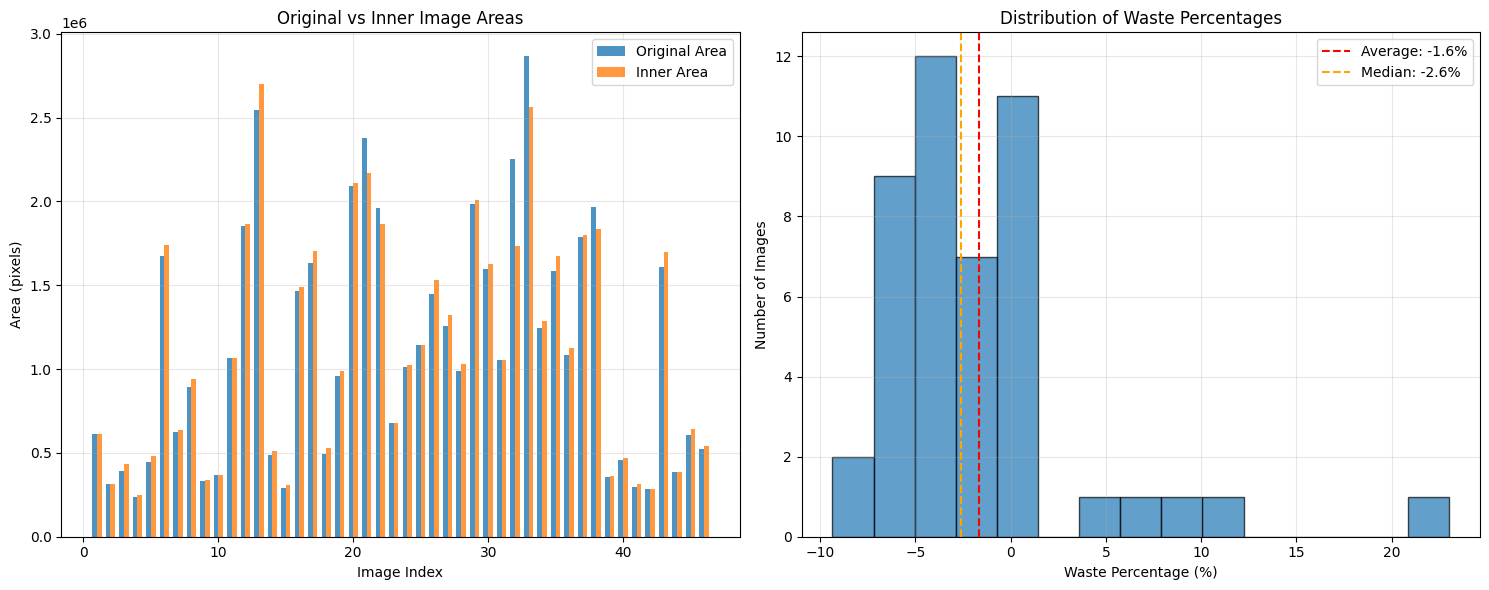

✅ Exported detailed statistics to: fabric_data/bag1_inner_image_area_analysis_detailed.csv
✅ Exported summary statistics to: fabric_data/bag1_inner_image_area_analysis_summary.csv
AREA DIFFERENCE ANALYSIS
Number of images processed: 37
Total original area: 47,360,619 pixels
Total inner area: 48,993,109 pixels
Total wasted area: -1,632,490 pixels
Overall waste percentage: -3.45%

Individual Image Statistics:
Average waste per image: -4.53%
Median waste per image: -4.90%
Min waste per image: -13.74%
Max waste per image: 9.49%
Standard deviation: 4.00%

Per-Image Breakdown:
------------------------------------------------------------
Image  1: 902,880 → 916,264 pixels (wasted: -13,384,  -1.5%)
Image  2: 2,499,196 → 2,556,718 pixels (wasted: -57,522,  -2.3%)
Image  3: 406,470 → 451,418 pixels (wasted: -44,948, -11.1%)
Image  4: 401,370 → 456,536 pixels (wasted: -55,166, -13.7%)
Image  5: 416,043 → 444,276 pixels (wasted: -28,233,  -6.8%)
Image  6: 400,113 → 430,344 pixels (wasted: -30,231,

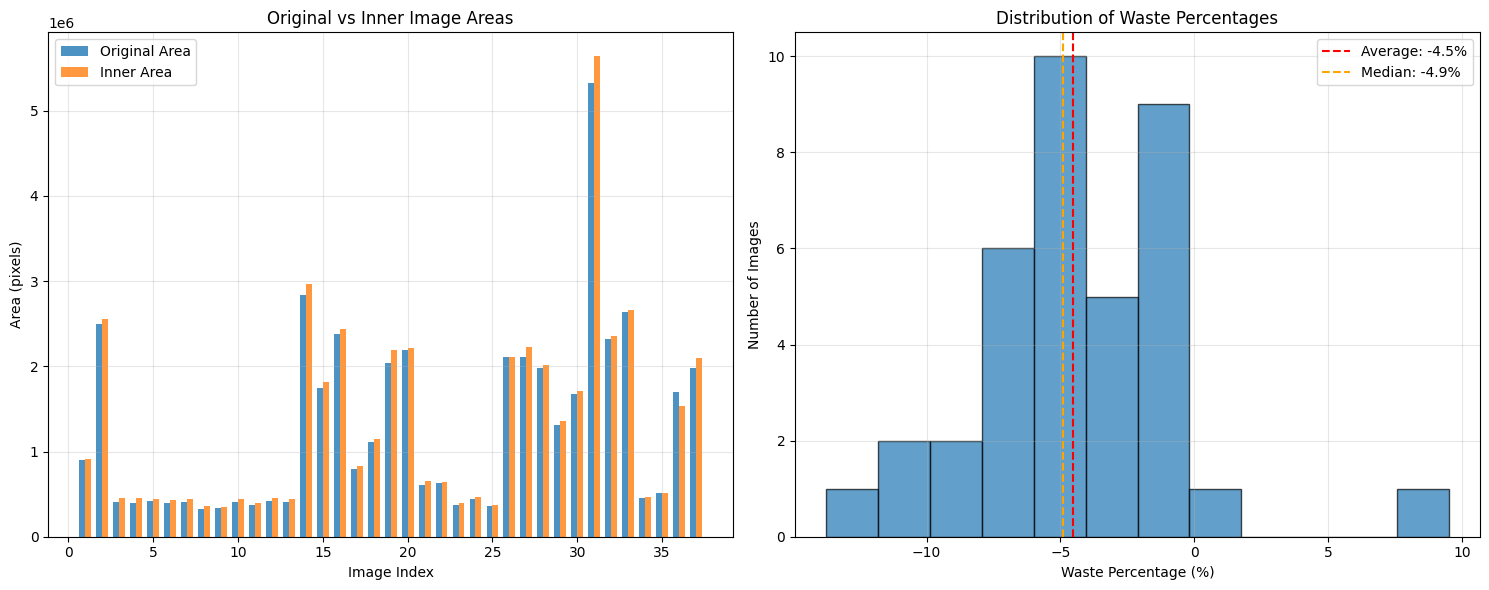

✅ Exported detailed statistics to: fabric_data/bag4_inner_image_area_analysis_detailed.csv
✅ Exported summary statistics to: fabric_data/bag4_inner_image_area_analysis_summary.csv
AREA DIFFERENCE ANALYSIS
Number of images processed: 66
Total original area: 15,748,534 pixels
Total inner area: 16,312,988 pixels
Total wasted area: -564,454 pixels
Overall waste percentage: -3.58%

Individual Image Statistics:
Average waste per image: -3.22%
Median waste per image: -3.55%
Min waste per image: -14.66%
Max waste per image: 19.67%
Standard deviation: 5.78%

Per-Image Breakdown:
------------------------------------------------------------
Image  1: 423,120 → 425,537 pixels (wasted: -2,417,  -0.6%)
Image  2: 62,832 → 59,996 pixels (wasted:  2,836,   4.5%)
Image  3: 19,942 → 21,000 pixels (wasted: -1,058,  -5.3%)
Image  4: 32,640 → 33,578 pixels (wasted:   -938,  -2.9%)
Image  5: 18,304 → 16,500 pixels (wasted:  1,804,   9.9%)
Image  6: 420,798 → 442,543 pixels (wasted: -21,745,  -5.2%)
Image  7:

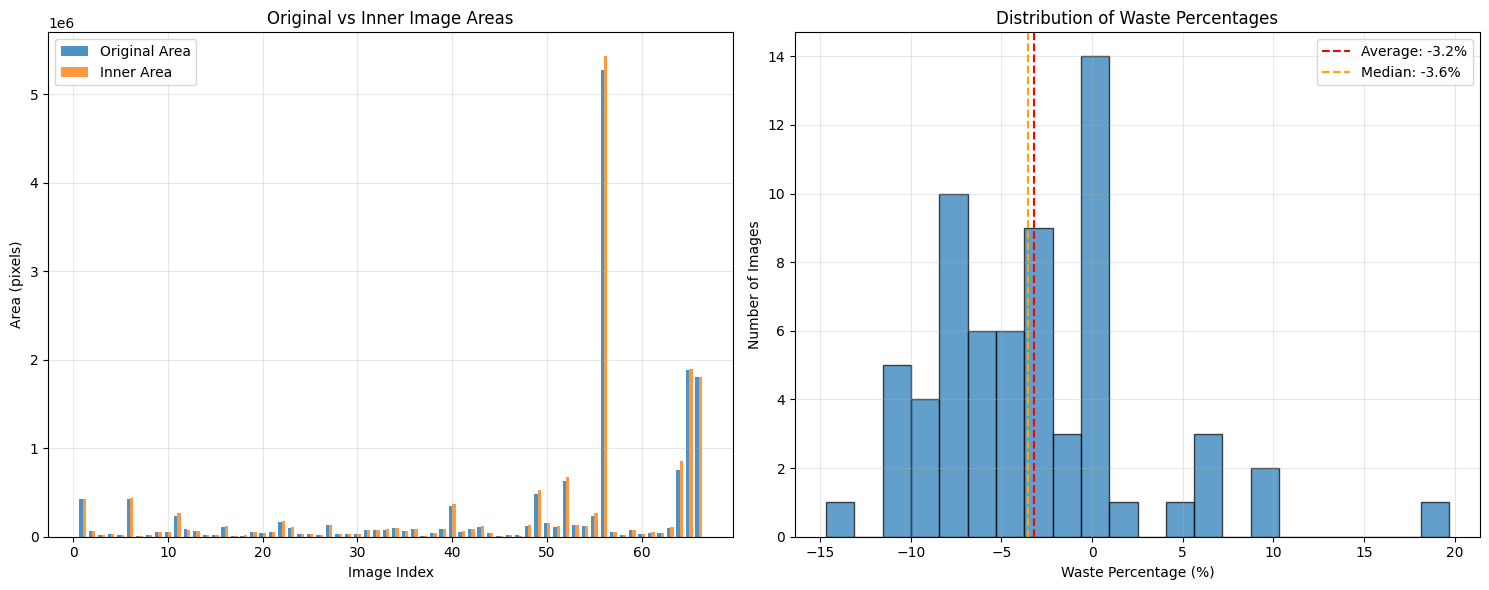

✅ Exported detailed statistics to: fabric_data/oren_inner_image_area_analysis_detailed.csv
✅ Exported summary statistics to: fabric_data/oren_inner_image_area_analysis_summary.csv
AREA DIFFERENCE ANALYSIS
Number of images processed: 122
Total original area: 24,494,001 pixels
Total inner area: 24,633,029 pixels
Total wasted area: -139,028 pixels
Overall waste percentage: -0.57%

Individual Image Statistics:
Average waste per image: -0.23%
Median waste per image: -0.62%
Min waste per image: -10.48%
Max waste per image: 22.62%
Standard deviation: 5.41%

Per-Image Breakdown:
------------------------------------------------------------
Image  1: 142,296 → 131,248 pixels (wasted: 11,048,   7.8%)
Image  2: 136,730 → 131,421 pixels (wasted:  5,309,   3.9%)
Image  3: 129,000 → 130,290 pixels (wasted: -1,290,  -1.0%)
Image  4: 133,100 → 131,396 pixels (wasted:  1,704,   1.3%)
Image  5: 150,524 → 137,388 pixels (wasted: 13,136,   8.7%)
Image  6: 160,325 → 140,082 pixels (wasted: 20,243,  12.6%)
I

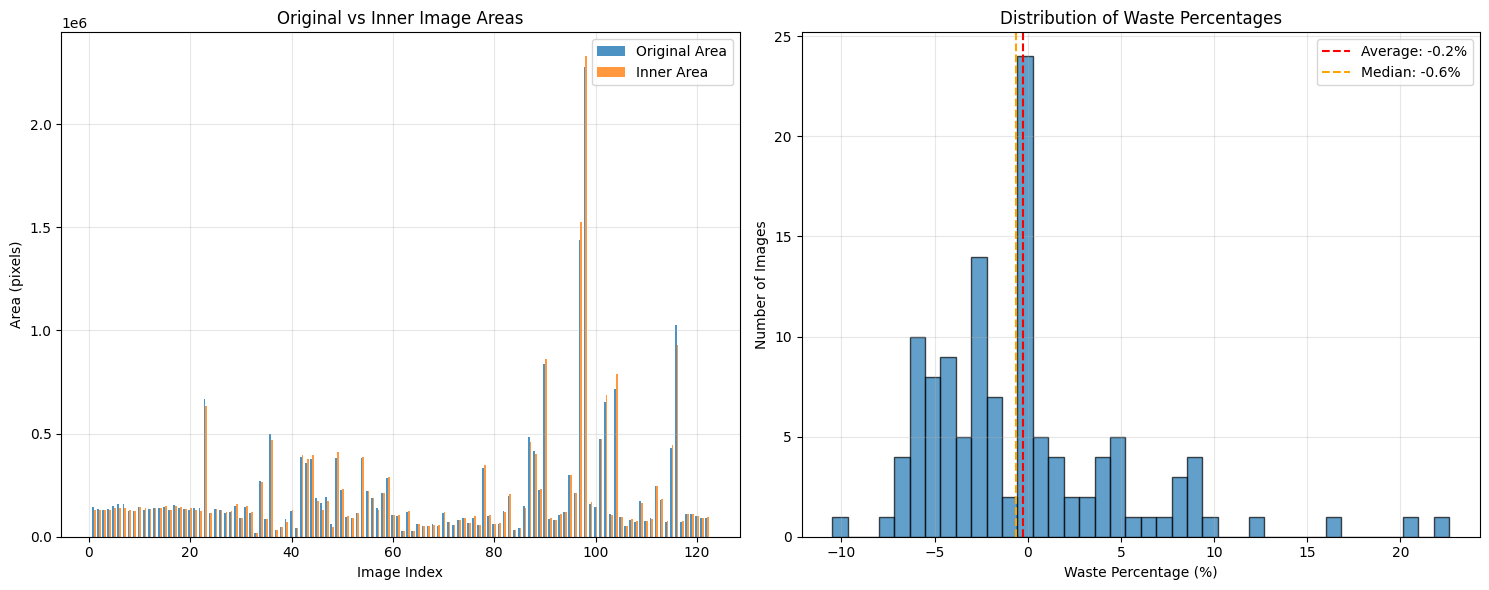

✅ Exported detailed statistics to: fabric_data/audrey_inner_image_area_analysis_detailed.csv
✅ Exported summary statistics to: fabric_data/audrey_inner_image_area_analysis_summary.csv


In [7]:
image_folders = [
    # 'fabric_data/etsybag',
    # 'fabric_data/bag1',
    # 'fabric_data/bag4',
    # 'fabric_data/fabscrap',
    # 'fabric_data/linen',
    # 'fabric_data/etsybag2',
    # 'fabric_data/solids', # <- this is combined from bag1 and bag4
    # 'fabric_data/oren',
    'fabric_data/audrey',
]
for image_folder in image_folders:
    list_of_images = load_images(image_folder)
    inner_images = [find_inner_bbox_aligned(image) for image in list_of_images]
    # inner_images = [find_inner_bbox(image) for image in aligned_images]
    # aligned_images = [align_image(img) for img in list_of_images]
    save_images(image_folder, inner_images)

In [ ]:
# from scripts.utils.plot import plot_images_in_grid
# plot_images_in_grid(inner_images, should_cvt_color=False)
plot_original_and_processed_images(list_of_images, inner_images)

In [3]:
#! DANGEROUS CELL DON'T RUN UNLESS YOU ARE SURE !#
def reindex_images(folder_path, start_index=0):
    """
    Reindex images in a folder starting from a given index
    Args:
        folder_path: Path to the folder containing images
        start_index: Starting index for renaming (default: 0)
    """
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')])
    
    # Create temporary names first to avoid overwriting
    for i, old_name in enumerate(image_files):
        old_path = os.path.join(folder_path, old_name)
        temp_path = os.path.join(folder_path, f"temp_{i + start_index}.png")
        os.rename(old_path, temp_path)
    
    # Rename to final names
    temp_files = sorted([f for f in os.listdir(folder_path) if f.startswith('temp_')])
    for temp_name in temp_files:
        old_path = os.path.join(folder_path, temp_name)
        new_name = f"{int(temp_name.split('_')[1].split('.')[0])}.png"
        new_path = os.path.join(folder_path, new_name)
        os.rename(old_path, new_path)

# reindex_images(image_folder, start_index=0)
# reindex_images(image_folder, start_index=25)

# reindex_images('fabric_data/studyset', start_index=0)
# reindex_images('fabric_data/adobe_seamless', start_index=0)

# reindex_images('fabric_data/studyset_post', start_index=0)
reindex_images('fabric_data/textured', start_index=0)
# reindex_images('fabric_data/linen_post', start_index=58)

def rename_images(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    image_files.sort(key=lambda x: int(x.split('.')[0]))
    sizes = [6, 4, 11, 8, 5, 7, 5]
    names = ['scrap1-1', 'scrap1-2', 'scrap2-1', 'scrap2-2', 'scrap2-3', 'scrap3-1', 'scrap3-2']
    index = 0
    for size_index, size in enumerate(sizes):
        for i in range(size):
            old_name = os.path.join(folder_path, image_files[i + index])
            new_name = os.path.join(folder_path, f'{names[size_index]}_Polygon{i+2}.png')
            print(old_name, new_name)
            os.rename(old_name, new_name)
        index += size
        old_name = os.path.join(folder_path, image_files[index])
        new_name = os.path.join(folder_path, f'{names[size_index]}_calib.png')
        print(old_name, new_name)
        index += 1
        os.rename(old_name, new_name)

# rename_images(image_folder)